In [1]:
# *****************************************************************************
#
#
# Purpose: Bayesian calibration of the Sick-Sicker 4-state Markov Model using 
#          Incremental Mixture Importance Sampling (IMIS)
#
# Authors: 
# This work is developed by the Decision Analysis in R for Technologies in Health 
# (DARTH) workgroup:
#
# - Fernando Alarid-Escudero, PhD
# - Eva A. Enns, MS, PhD 
# - M.G. Myriam Hunink, MD, PhD 
# - Hawre J. Jalal, MD, PhD 
# - Eline Krijkamp, PhD 
# - Petros Pechlivanoglou, PhD
# - Alan Yang, MSc
#
# *****************************************************************************
#
# Notes:
#
# Please acknowledge our work. See details to cite below:
#
# - Alarid-Escudero F, MacLehose RF, Peralta Y, Kuntz KM, Enns EA. 
#   Non-identifiability in model calibration and implications for 
#   medical decision making. Med Decis Making. 2018; 38(7):810-821.
#
# - Jalal H, Pechlivanoglou P, Krijkamp E, Alarid-Escudero F, Enns E, 
#   Hunink MG. An Overview of R in Health Decision Sciences. 
#   Med Decis Making. 2017; 37(3): 735-746.
#
# *****************************************************************************

# ******************************************************************************
# 01 Calibration Overview ------------------------------------------------------
# ******************************************************************************

### 01.01 Model description  ---------------------------------------------------
# Model: Sick-Sicker 4-state Markov Model
# Inputs to be calibrated: p_S1S2, hr_S1, hr_S2
# Targets: Surv, Prev, PropSick

### 01.02 Calibration method  --------------------------------------------------
# Search method: Incremental Mixture Importance Sampling (IMIS)
# Goodness-of-fit measure: Sum of Log-Likelihood


In [2]:
# ******************************************************************************
# 02 Setup ---------------------------------------------------------------------
# ******************************************************************************

### 02.01 Clear environment  ---------------------------------------------------
rm(list = ls())

### 02.02 Load packages  -------------------------------------------------------
# Install pacman if not present
if (!requireNamespace("pacman", quietly = TRUE)) install.packages("pacman")

# Load pacman
library(pacman)

# Load (install if needed) CRAN packages
p_load(
  lhs,          # Latin Hypercube Sampling
  IMIS,         # Incremental Mixture Importance Sampling
  matrixStats,  # Summary statistics
  plotrix,      # Plotting with confidence intervals
  psych,        # Pairs panels
  scatterplot3d,# 3D scatter plots
  ggplot2,      # Advanced plotting
  GGally,       # Pairwise plots
  dplyr,        # Data manipulation
  reshape2      # Data reshaping
)

# Note: Install IMIS from CRAN archive if needed
# devtools::install_version("IMIS", version = "0.1", repos = "http://cran.us.r-project.org")

In [3]:
# ******************************************************************************
# 03 Load calibration targets --------------------------------------------------
# ******************************************************************************

### 03.01 Load target data  ----------------------------------------------------
load("../../data/SickSicker_CalibTargets.RData")
lst_targets <- SickSicker_targets

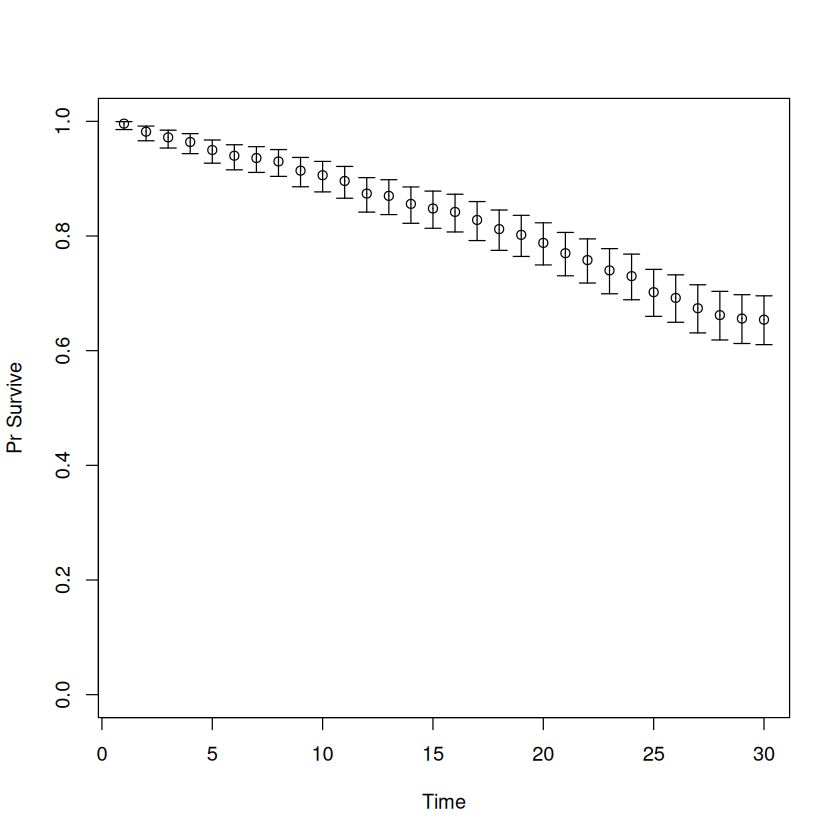

In [4]:
### 03.02 Visualize calibration targets  ---------------------------------------
# TARGET 1: Survival ("Surv")
plotrix::plotCI(x = lst_targets$Surv$time, 
                y = lst_targets$Surv$value, 
                ui = lst_targets$Surv$ub,
                li = lst_targets$Surv$lb,
                ylim = c(0, 1), 
                xlab = "Time", 
                ylab = "Pr Survive")

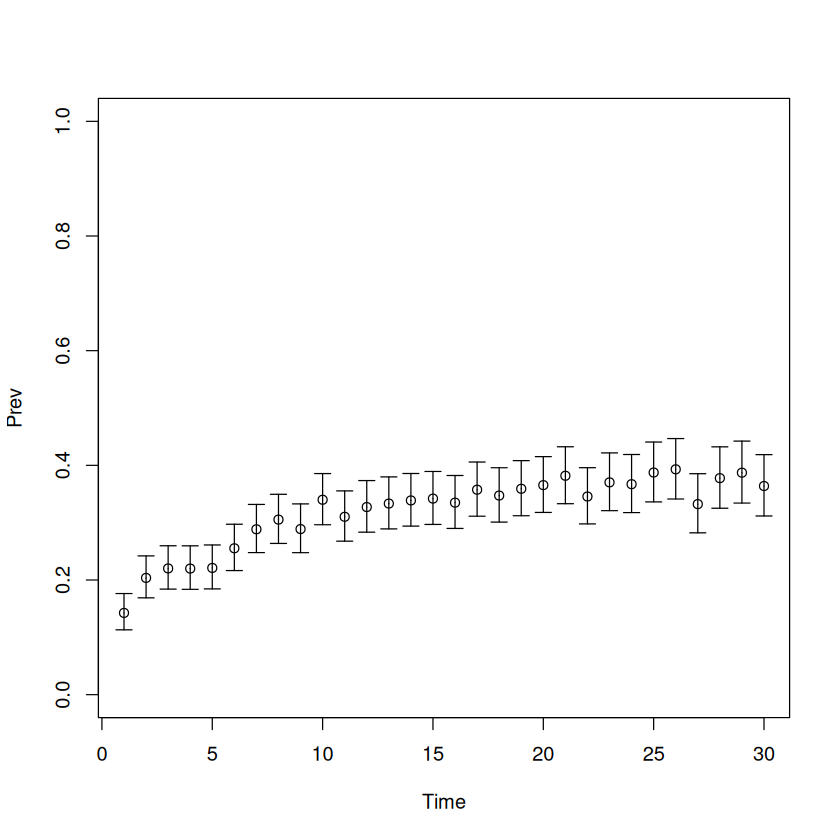

In [5]:
# TARGET 2: Prevalence ("Prev")
plotrix::plotCI(x = lst_targets$Prev$time, 
                y = lst_targets$Prev$value,
                ui = lst_targets$Prev$ub,
                li = lst_targets$Prev$lb,
                ylim = c(0, 1),
                xlab = "Time", 
                ylab = "Prev")

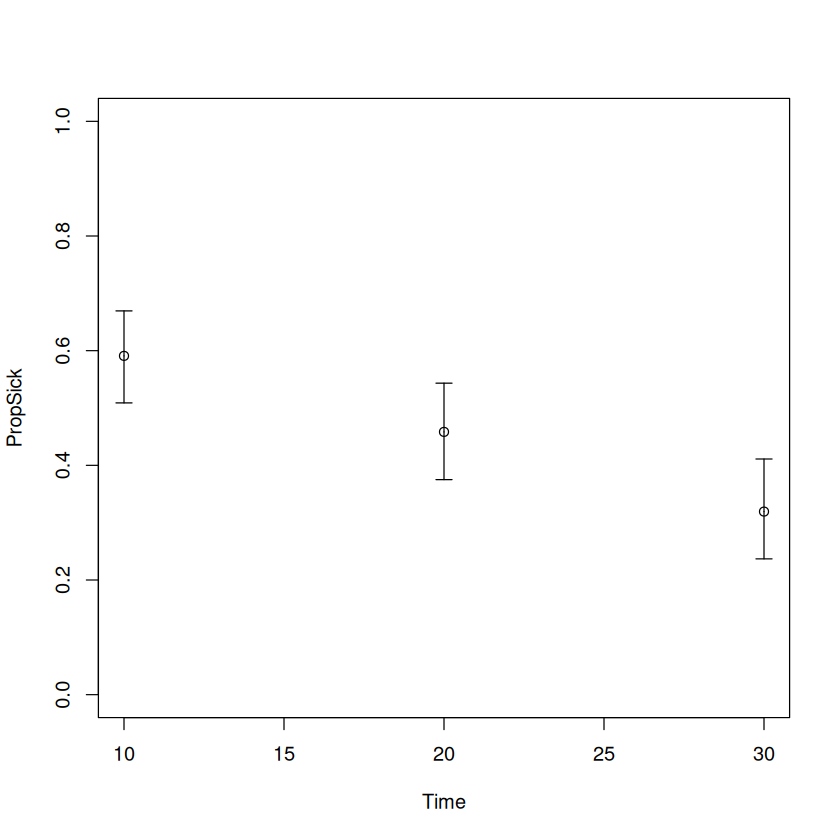

In [6]:
# TARGET 3: Proportion who are Sick ("PropSick"), among all those afflicted (Sick+Sicker)
plotrix::plotCI(x = lst_targets$PropSick$time, 
                y = lst_targets$PropSick$value,
                ui = lst_targets$PropSick$ub,
                li = lst_targets$PropSick$lb,
                ylim = c(0, 1),
                xlab = "Time", 
                ylab = "PropSick")

In [7]:
# ******************************************************************************
# 04 Load model as a function --------------------------------------------------
# ******************************************************************************

### 04.01 Source model function  -----------------------------------------------
# Function inputs: parameters to be estimated through calibration
# Function outputs: model predictions corresponding to target data
source("../../code/Functions/SickSicker_MarkovModel_Function.R") # creates run_sick_sicker_markov()

### 04.02 Test model function  -------------------------------------------------
v_params_test <- c(p_S1S2 = 0.105, hr_S1 = 3, hr_S2 = 10)
run_sick_sicker_markov(v_params_test) # Test: function works correctly

$Surv
        1         2         3         4         5         6         7         8 
0.9950000 0.9885362 0.9810784 0.9728008 0.9637994 0.9541472 0.9439082 0.9331413 
        9        10        11        12        13        14        15        16 
0.9219015 0.9102402 0.8982055 0.8858421 0.8731922 0.8602948 0.8471865 0.8339014 
       17        18        19        20        21        22        23        24 
0.8204713 0.8069256 0.7932918 0.7795955 0.7658602 0.7521079 0.7383588 0.7246318 
       25        26        27        28        29        30 
0.7109441 0.6973115 0.6837488 0.6702694 0.6568856 0.6436086 

$Prev
        1         2         3         4         5         6         7         8 
0.1507538 0.2018249 0.2267624 0.2443252 0.2593508 0.2731265 0.2860289 0.2981972 
        9        10        11        12        13        14        15        16 
0.3097057 0.3206084 0.3309506 0.3407725 0.3501104 0.3589973 0.3674630 0.3755352 
       17        18        19        20        21        22        23        24 
0.3832387 0.3905968 0.3976304 0.4043591 0.4108009 0.4169723 0.4228887 0.4285642 
       25        26        27        28        29        30 
0.4340120 0.4392445 0.4442729 0.4491079 0.4537594 0.4582367 

$PropSick
       10        20        30 
0.5372139 0.3734392 0.2997246

In [8]:
# ******************************************************************************
# 05 Calibration specifications ------------------------------------------------
# ******************************************************************************

### 05.01 Set random seed  -----------------------------------------------------
set.seed(072218) # For reproducible sequence of random numbers

### 05.02 Define calibration parameters  ---------------------------------------
# Number of posterior samples desired
n_resamp <- 1000

# Names and number of parameters to calibrate
v_param_names <- c("p_S1S2", "hr_S1", "hr_S2")
n_param       <- length(v_param_names)

# Search space bounds
v_lb <- c(p_S1S2 = 0.01, hr_S1 = 1, hr_S2 = 1)    # lower bound
v_ub <- c(p_S1S2 = 0.50, hr_S1 = 12, hr_S2 = 25)  # upper bound

### 05.03 Define calibration targets  ------------------------------------------
v_target_names <- c("Surv", "Prev", "PropSick")
n_target       <- length(v_target_names)

### 05.04 Define target indices  -----------------------------------------------
# A list to index each target
l_index <- list(
  Surv     = 1:30,  # 30 time points
  Prev     = 1:30,  # 30 time points
  PropSick = 3      # 3 time points
)

p_S1S2 
-4.862599

[1] -4.862599 -4.862599 -4.862599 -4.862599 -4.862599 -4.862599 -4.862599
 [8] -4.862599 -4.862599 -4.862599

p_S1S2 
0.007730365

[1] 0.007730365 0.007730365 0.007730365 0.007730365 0.007730365 0.007730365
 [7] 0.007730365 0.007730365 0.007730365 0.007730365

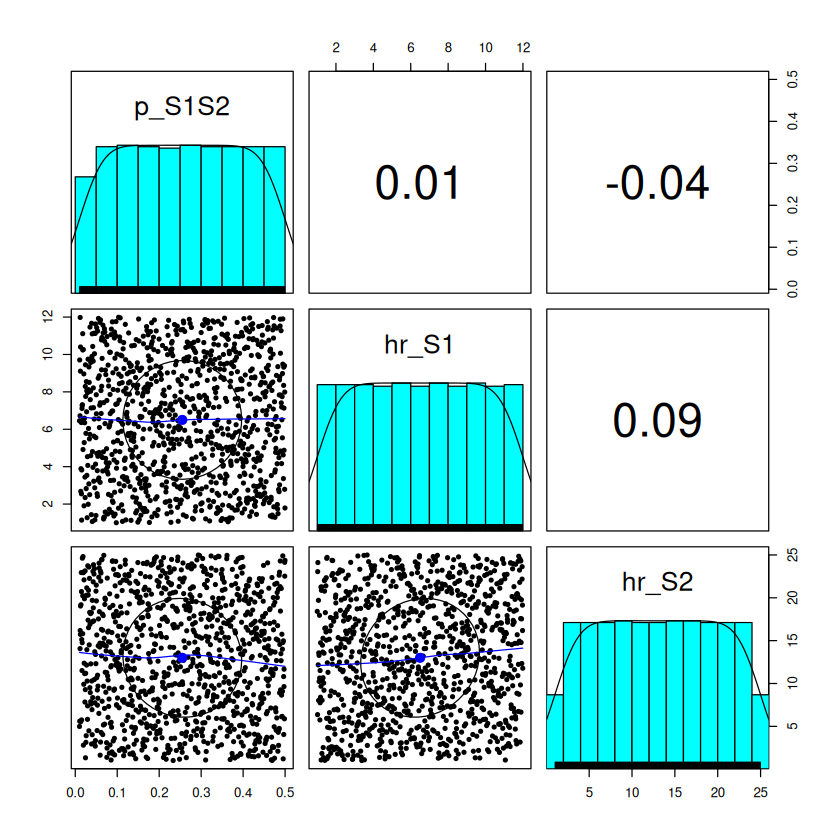

In [9]:
# ******************************************************************************
# 06 Prior distribution functions ----------------------------------------------
# ******************************************************************************

### 06.01 Function to sample from prior  ---------------------------------------
sample_prior <- function(n_samp){
  # Generate Latin Hypercube Sample
  m_lhs_unit   <- randomLHS(n = n_samp, k = n_param)
  m_param_samp <- matrix(nrow = n_samp, ncol = n_param)
  colnames(m_param_samp) <- v_param_names
  
  # Transform to parameter space using uniform distribution
  for (i in 1:n_param) {
    m_param_samp[, i] <- qunif(m_lhs_unit[, i],
                               min = v_lb[i],
                               max = v_ub[i])
  }
  return(m_param_samp)
}

### 06.02 Visualize prior samples  ---------------------------------------------
pairs.panels(sample_prior(1000))

### 06.03 Function to calculate log-prior  -------------------------------------
calc_log_prior <- function(v_params){
  if (is.null(dim(v_params))) { # If vector, change to matrix
    v_params <- t(v_params) 
  }
  n_samp <- nrow(v_params)
  colnames(v_params) <- v_param_names
  lprior <- rep(0, n_samp)
  
  # Calculate log-prior using uniform distribution
  for (i in 1:n_param) {
    lprior <- lprior + dunif(v_params[, i],
                             min = v_lb[i],
                             max = v_ub[i], 
                             log = TRUE)
  }
  return(lprior)
}

### 06.04 Function to calculate prior  -----------------------------------------
calc_prior <- function(v_params) { 
  exp(calc_log_prior(v_params)) 
}

### 06.05 Test prior functions  ------------------------------------------------
calc_log_prior(v_params = v_params_test)
calc_log_prior(v_params = sample_prior(10))
calc_prior(v_params = v_params_test)
calc_prior(v_params = sample_prior(10))

In [10]:
# ******************************************************************************
# 07 Likelihood functions ------------------------------------------------------
# ******************************************************************************

### 07.01 Function to calculate log-likelihood  --------------------------------
calc_log_lik <- function(v_params){
  if (is.null(dim(v_params))) { # If vector, change to matrix
    v_params <- t(v_params) 
  }
  n_samp <- nrow(v_params)
  v_llik <- matrix(0, nrow = n_samp, ncol = n_target) 
  llik_overall <- numeric(n_samp)
  
  for (j in 1:n_samp) { # j = 1
    jj <- tryCatch({ 
      # Run model for parameter set v_params
      model_res <- run_sick_sicker_markov(v_params[j, ])
      
      # Calculate log-likelihood for TARGET 1: Survival
      v_llik[j, 1] <- sum(dnorm(x = lst_targets$Surv$value[l_index$Surv], 
                                mean = model_res$Surv[l_index$Surv], 
                                sd = lst_targets$Surv$se[l_index$Surv],
                                log = TRUE))
      
      # Calculate log-likelihood for TARGET 2: Prevalence
      v_llik[j, 2] <- sum(dnorm(x = lst_targets$Prev$value[l_index$Prev], 
                                mean = model_res$Prev[l_index$Prev],
                                sd = lst_targets$Prev$se[l_index$Prev],
                                log = TRUE))
      
      # Calculate log-likelihood for TARGET 3: PropSick
      v_llik[j, 3] <- sum(dnorm(x = lst_targets$PropSick$value[l_index$PropSick],
                                mean = model_res$PropSick[l_index$PropSick],
                                sd = lst_targets$PropSick$se[l_index$PropSick],
                                log = TRUE))
      
      # Calculate overall log-likelihood
      llik_overall[j] <- sum(v_llik[j, ])
    }, error = function(e) NA) 
    
    if (is.na(jj)) { llik_overall[j] <- -Inf }
  }
  return(llik_overall)
}

### 07.02 Function to calculate likelihood  ------------------------------------
calc_likelihood <- function(v_params){ 
  exp(calc_log_lik(v_params)) 
}

### 07.03 Test likelihood functions  -------------------------------------------
calc_log_lik(v_params = v_params_test)
calc_log_lik(v_params = sample_prior(10))
calc_likelihood(v_params = v_params_test)
calc_likelihood(v_params = sample_prior(10))

[1] 134.1498

[1]  -330.27320  -394.33104 -2085.15436 -1061.82314 -2814.84349 -2070.56313
 [7] -2724.88584 -1125.71868    99.08085    70.83796

[1] 1.821927e+58

[1]  0.000000e+00  0.000000e+00  0.000000e+00  4.743017e-17  0.000000e+00
 [6]  0.000000e+00 1.257495e-119  1.955956e+23  0.000000e+00  8.131848e+70

In [11]:
# ******************************************************************************
# 08 Posterior distribution functions ------------------------------------------
# ******************************************************************************

### 08.01 Function to calculate log-posterior  ---------------------------------
calc_log_post <- function(v_params) { 
  lpost <- calc_log_prior(v_params) + calc_log_lik(v_params)
  return(lpost) 
}

### 08.02 Function to calculate posterior  -------------------------------------
calc_post <- function(v_params) { 
  exp(calc_log_post(v_params)) 
}

### 08.03 Test posterior functions  --------------------------------------------
calc_log_post(v_params = v_params_test)
calc_log_post(v_params = sample_prior(10))
calc_post(v_params = v_params_test)
calc_post(v_params = sample_prior(10))

p_S1S2 
129.2872

[1] -3667.6514 -2893.2479 -1263.1207  -181.0145 -3278.0175  -881.6594
 [7]   118.5332  -367.4836  -501.7406 -1653.1355

p_S1S2 
1.408416e+56

[1]  7.982191e+05  0.000000e+00  0.000000e+00  5.778467e-74  0.000000e+00
 [6] 1.154025e-138  0.000000e+00 5.088980e-108 3.554023e-298  0.000000e+00

In [12]:
# ******************************************************************************
# 09 Run Bayesian calibration using IMIS ---------------------------------------
# ******************************************************************************

### 09.01 Record start time  ---------------------------------------------------
t_init <- Sys.time()

### 09.02 Define IMIS functions  -----------------------------------------------
prior        <- calc_prior
likelihood   <- calc_likelihood
sample.prior <- sample_prior

### 09.03 Run IMIS algorithm  --------------------------------------------------
fit_imis <- IMIS(
  B = 1000,         # Incremental sample size at each iteration
  B.re = n_resamp,  # Desired posterior sample size
  number_k = 10,    # Maximum number of iterations
  D = 0             # Number of samples to be deleted at each iteration
)

### 09.04 Extract posterior samples  -------------------------------------------
m_calib_res <- fit_imis$resample

### 09.05 Calculate posterior diagnostics  -------------------------------------
# Calculate log-likelihood and posterior probability for each sample
m_calib_res <- cbind(
  m_calib_res, 
  "Overall_fit" = calc_log_lik(m_calib_res[, v_param_names]),
  "Posterior_prob" = calc_post(m_calib_res[, v_param_names])
)

# Normalize posterior probabilities
m_calib_res[, "Posterior_prob"] <- m_calib_res[, "Posterior_prob"] / 
  sum(m_calib_res[, "Posterior_prob"])

### 09.06 Calculate computation time  ------------------------------------------
comp_time <- Sys.time() - t_init
comp_time




[1] "10000 likelihoods are evaluated in 0.1 minutes"
[1] "Stage   MargLike   UniquePoint   MaxWeight   ESS"
[1]   1.000 163.868  15.158   0.487   3.006
[1]   2.000 163.614 166.368   0.025  92.126
[1]   3.000 163.845 336.331   0.010 256.781
[1]   4.000 163.765 452.222   0.006 406.355
[1]    5.000  163.789  670.449    0.003 1044.769


Time difference of 9.361996 secs

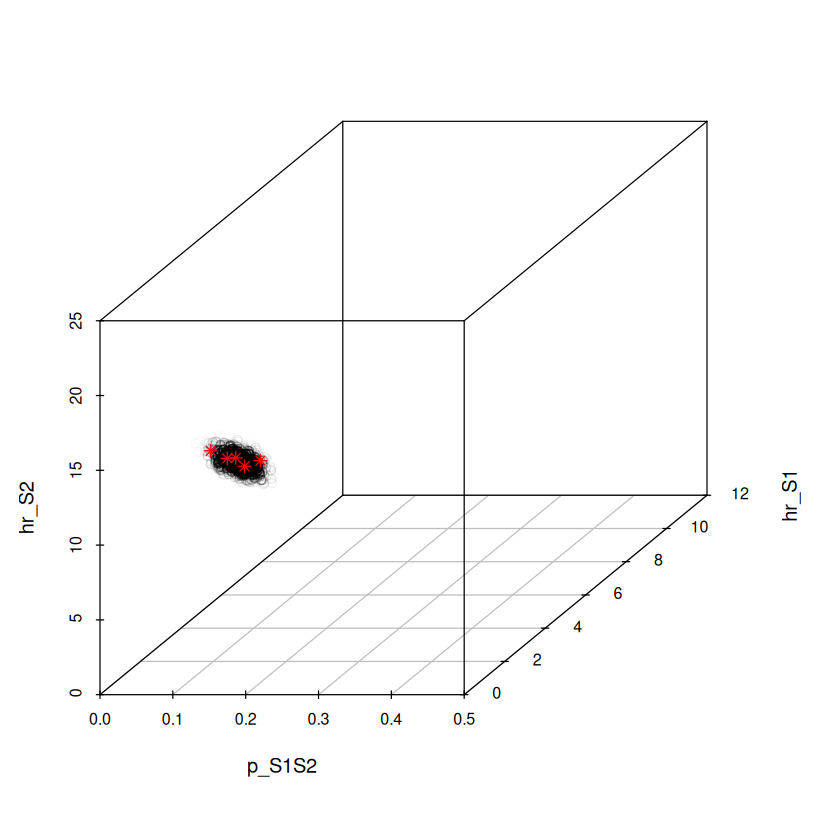

p_S1S2       hr_S1       hr_S2 
 0.07855889  4.00365623 11.12562312

,2.5%,50%,97.5%
p_S1S2,0.06860931,0.07851089,0.08884351
hr_S1,2.36478240,4.05853507,5.48519068
hr_S2,8.38365780,11.11650663,13.94741475


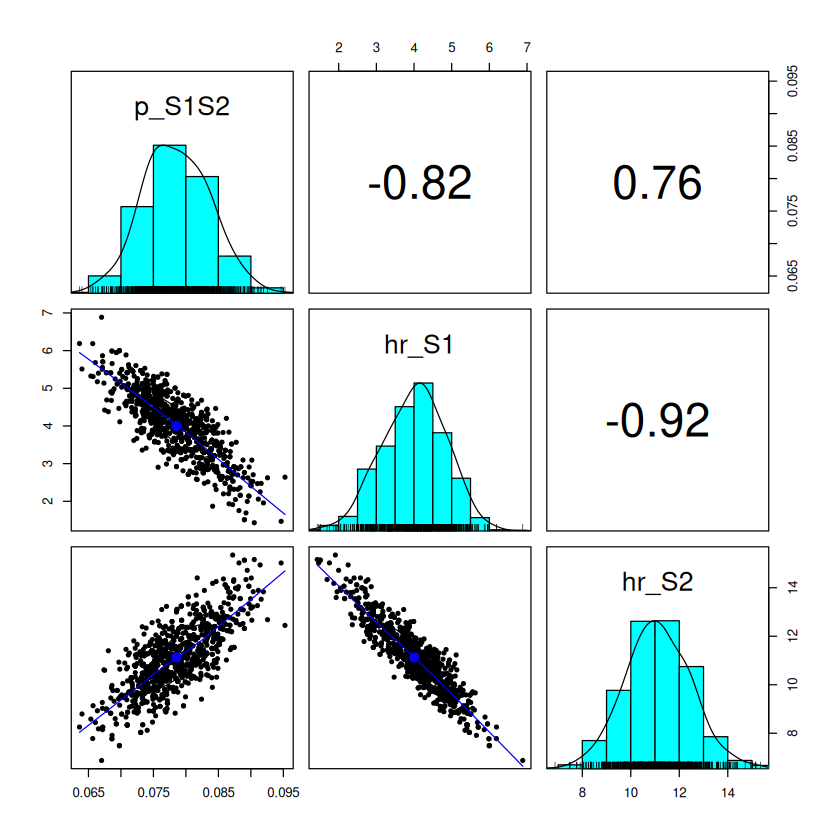

In [13]:
# ******************************************************************************
# 10 Explore posterior distribution --------------------------------------------
# ******************************************************************************

### 10.01 Visualize posterior samples in 3D  -----------------------------------
# Color points by posterior probability
v_post_color <- scales::rescale(m_calib_res[, "Posterior_prob"])

s3d <- scatterplot3d(
  x = m_calib_res[, 1],
  y = m_calib_res[, 2],
  z = m_calib_res[, 3],
  color = scales::alpha("black", v_post_color),
  xlim = c(v_lb[1], v_ub[1]), 
  ylim = c(v_lb[2], v_ub[2]), 
  zlim = c(v_lb[3], v_ub[3]),
  xlab = v_param_names[1], 
  ylab = v_param_names[2], 
  zlab = v_param_names[3]
)

# Add centers of Gaussian components
s3d$points3d(fit_imis$center, col = "red", pch = 8)

### 10.02 Pairwise plots with marginal histograms  -----------------------------
pairs.panels(m_calib_res[, v_param_names])

### 10.03 Calculate posterior summary statistics  ------------------------------
# Posterior mean
v_calib_post_mean <- colMeans(m_calib_res[, v_param_names])
v_calib_post_mean

# Posterior median and 95% credible interval
m_calib_res_95cr <- colQuantiles(m_calib_res[, v_param_names], 
                                 probs = c(0.025, 0.5, 0.975))
m_calib_res_95cr

# Maximum-a-posteriori (MAP) parameter set
v_calib_map <- m_calib_res[which.max(m_calib_res[, "Posterior_prob"]), ]

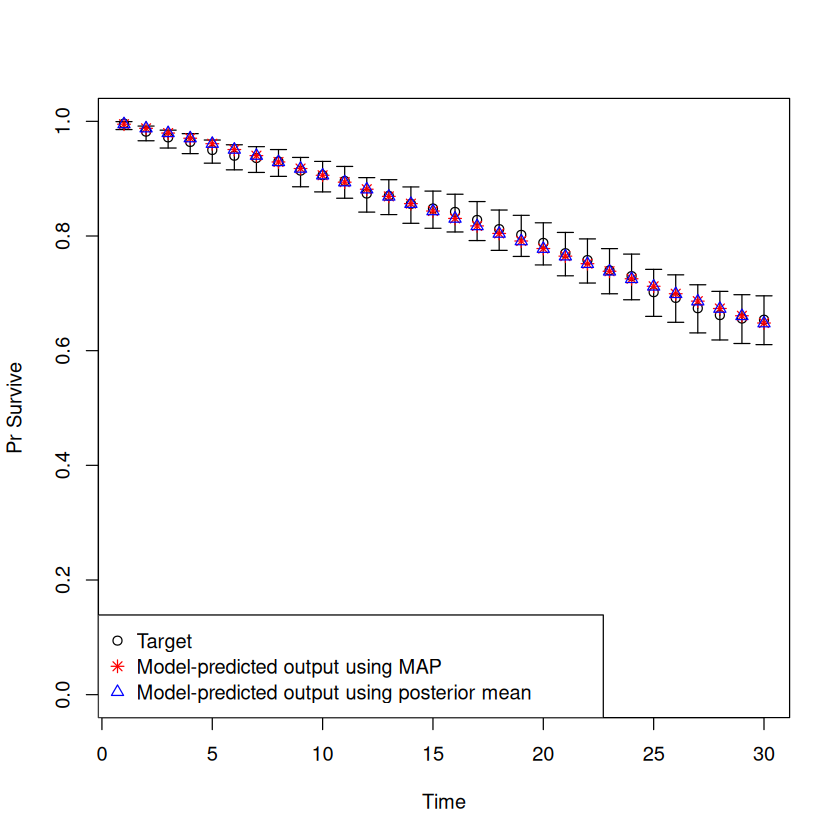

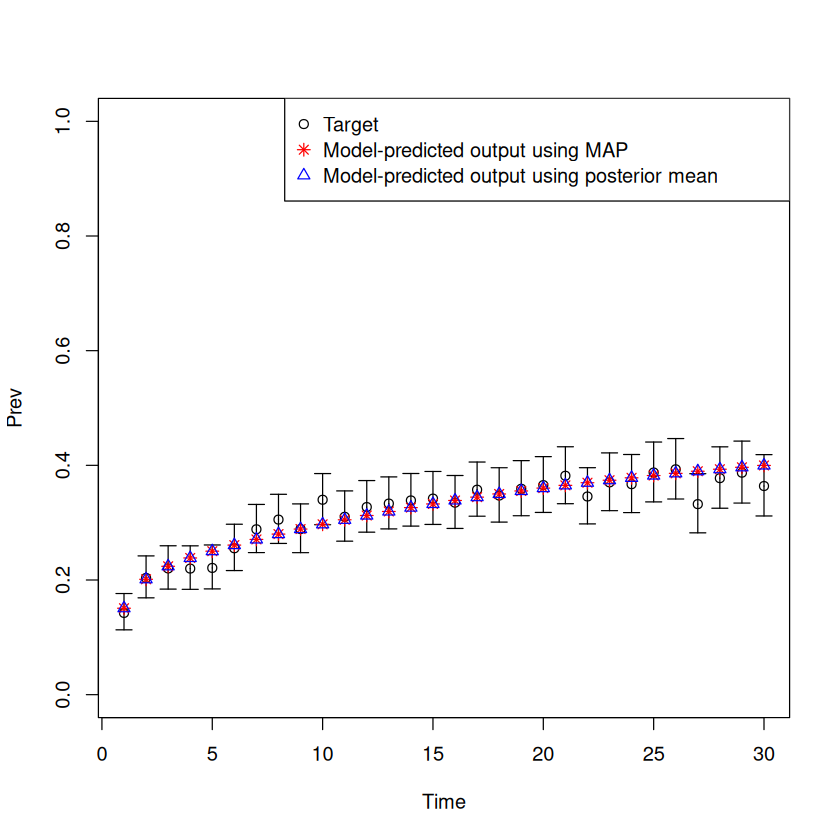

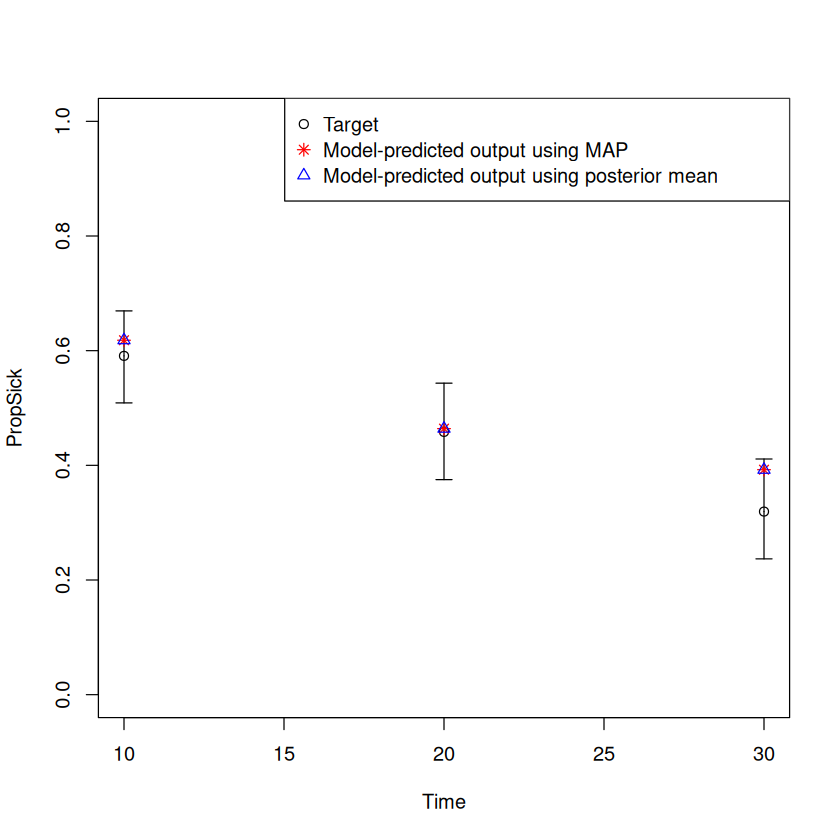

In [14]:
### 10.04 Compare model predictions to targets  --------------------------------
# Compute output from MAP
v_out_map <- run_sick_sicker_markov(v_calib_map[v_param_names])

# Compute output from posterior mean
v_out_post_mean <- run_sick_sicker_markov(v_calib_post_mean)

# Plot: TARGET 1: Survival
plotrix::plotCI(x = lst_targets$Surv$time, 
                y = lst_targets$Surv$value, 
                ui = lst_targets$Surv$ub,
                li = lst_targets$Surv$lb,
                ylim = c(0, 1), 
                xlab = "Time", 
                ylab = "Pr Survive")

points(x = lst_targets$Surv$time, 
       y = v_out_map$Surv, 
       pch = 8, col = "red")

points(x = lst_targets$Surv$time, 
       y = v_out_post_mean$Surv, 
       pch = 2, col = "blue")

legend("bottomleft", 
       legend = c("Target", 
                  "Model-predicted output using MAP",
                  "Model-predicted output using posterior mean"),
       col = c("black", "red", "blue"), 
       pch = c(1, 8, 2))

# Plot: TARGET 2: Prevalence
plotrix::plotCI(x = lst_targets$Prev$time, 
                y = lst_targets$Prev$value,
                ui = lst_targets$Prev$ub,
                li = lst_targets$Prev$lb,
                ylim = c(0, 1),
                xlab = "Time", 
                ylab = "Prev")

points(x = lst_targets$Prev$time,
       y = v_out_map$Prev,
       pch = 8, col = "red")

points(x = lst_targets$Prev$time,
       y = v_out_post_mean$Prev,
       pch = 2, col = "blue")

legend("topright", 
       legend = c("Target", 
                  "Model-predicted output using MAP",
                  "Model-predicted output using posterior mean"),
       col = c("black", "red", "blue"), 
       pch = c(1, 8, 2))

# Plot: TARGET 3: PropSick
plotrix::plotCI(x = lst_targets$PropSick$time, 
                y = lst_targets$PropSick$value,
                ui = lst_targets$PropSick$ub,
                li = lst_targets$PropSick$lb,
                ylim = c(0, 1),
                xlab = "Time", 
                ylab = "PropSick")

points(x = lst_targets$PropSick$time,
       y = v_out_map$PropSick,
       pch = 8, col = "red")

points(x = lst_targets$PropSick$time,
       y = v_out_post_mean$PropSick,
       pch = 2, col = "blue")

legend("topright", 
       legend = c("Target", 
                  "Model-predicted output using MAP",
                  "Model-predicted output using posterior mean"),
       col = c("black", "red", "blue"), 
       pch = c(1, 8, 2))

`stat_bin()` using `bins = 30`. Pick better value `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


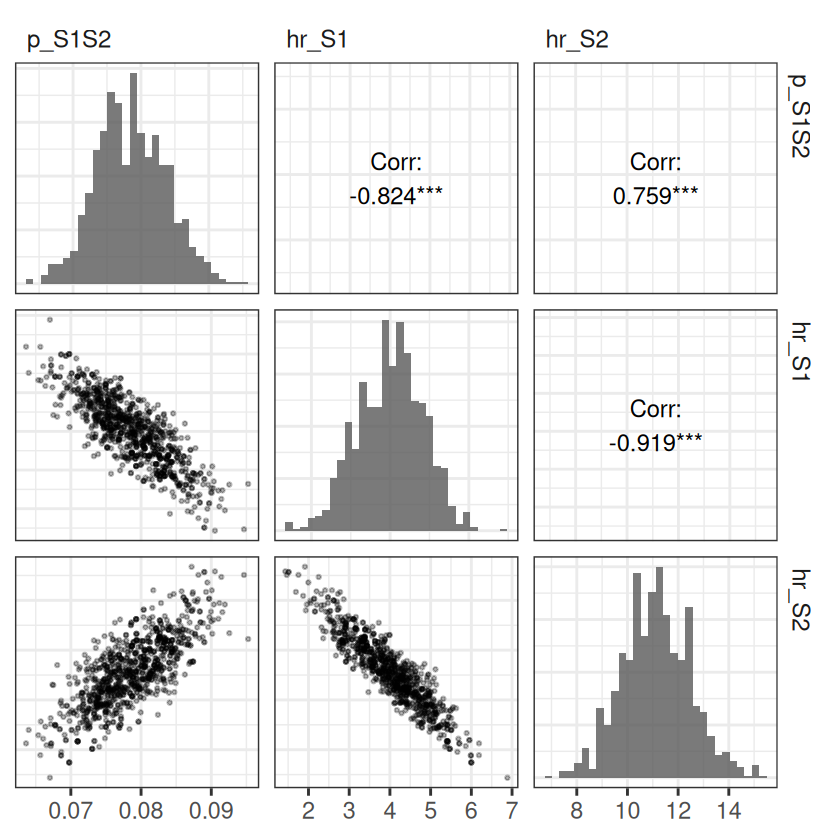

In [15]:
### 10.05 Advanced visualization: pairwise correlations  -----------------------
gg_post_pairs_corr <- GGally::ggpairs(
  data.frame(m_calib_res[, v_param_names]),
  upper = list(continuous = wrap("cor",
                                 color = "black",
                                 size = 5)),
  diag = list(continuous = wrap("barDiag",
                                alpha = 0.8)),
  lower = list(continuous = wrap("points", 
                                 alpha = 0.3,
                                 size = 0.7)),
  columnLabels = v_param_names
) +
  theme_bw(base_size = 18) +
  theme(axis.title.x = element_blank(),
        axis.text.x = element_text(size = 14),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        strip.background = element_rect(fill = "white",
                                        color = "white"),
        strip.text = element_text(hjust = 0))
gg_post_pairs_corr

Using PDF as id variables

Using PDF as id variables

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


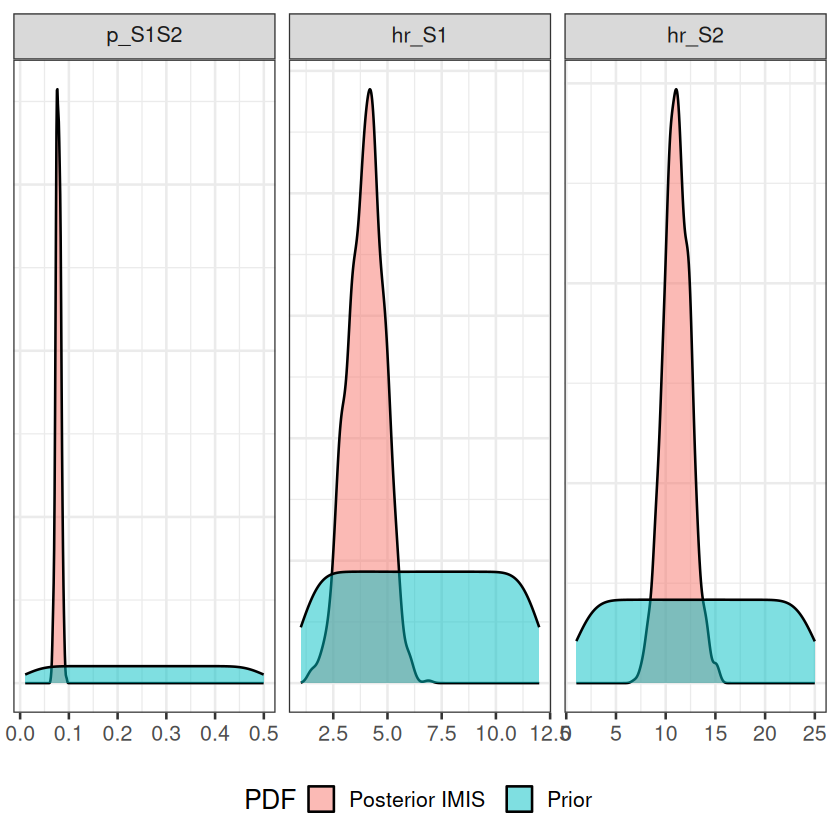

In [16]:
### 10.06 Prior vs posterior comparison  ---------------------------------------
# Sample from prior
m_samp_prior <- sample.prior(n_resamp)

# Prepare data for plotting
df_samp_prior <- reshape2::melt(
  cbind(PDF = "Prior", as.data.frame(m_samp_prior)), 
  variable.name = "Parameter"
)

df_samp_post_imis <- reshape2::melt(
  cbind(PDF = "Posterior IMIS", 
        as.data.frame(m_calib_res[, v_param_names])),
  variable.name = "Parameter"
)

df_samp_prior_post <- dplyr::bind_rows(df_samp_prior, df_samp_post_imis)

# Plot prior vs posterior
gg_prior_post_imis <- ggplot(df_samp_prior_post, 
                             aes(x = value, y = ..density.., fill = PDF)) +
  facet_wrap(~Parameter, scales = "free", 
             ncol = 4,
             labeller = label_parsed) +
  scale_x_continuous(n.breaks = 6) +
  geom_density(alpha = 0.5) +
  theme_bw(base_size = 16) +
  theme(legend.position = "bottom",
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank())
gg_prior_post_imis

 100% done

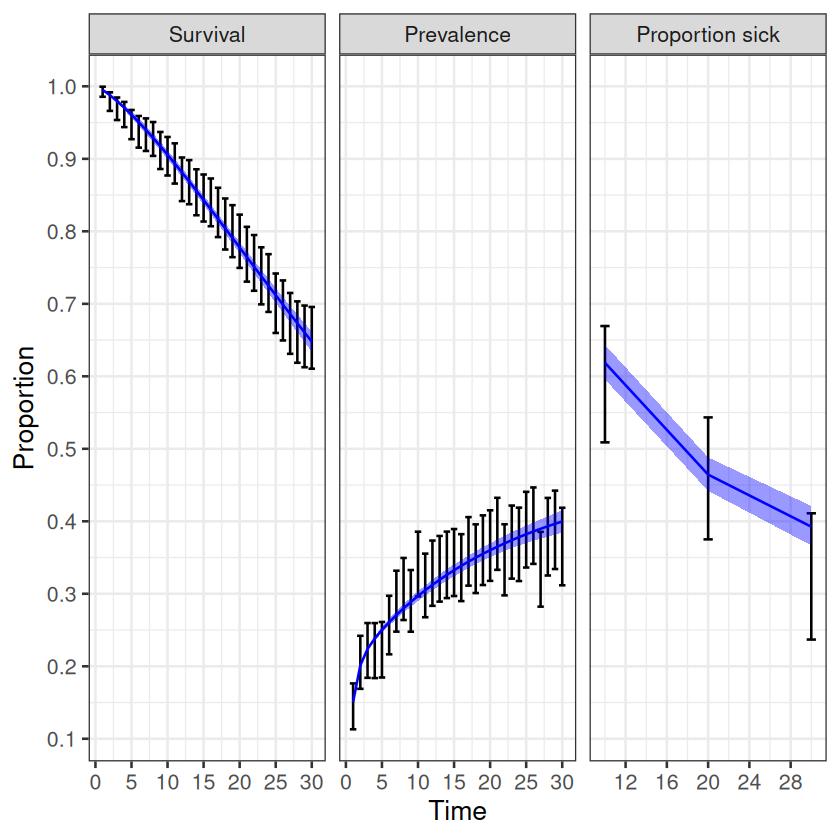

In [17]:
# ******************************************************************************
# 11 Propagate parameter uncertainty -------------------------------------------
# ******************************************************************************

### 11.01 Initialize output matrices  ------------------------------------------
m_out_surv     <- matrix(NA, 
                         nrow = n_resamp, 
                         ncol = length(lst_targets$Surv$value))  

m_out_prev     <- matrix(NA, 
                         nrow = n_resamp, 
                         ncol = length(lst_targets$Prev$value))  

m_out_propsick <- matrix(NA, 
                         nrow = n_resamp, 
                         ncol = length(lst_targets$PropSick$value))   

### 11.02 Run model for each posterior parameter set  --------------------------
for (i in 1:n_resamp) { # i = 1
  model_res_temp <- run_sick_sicker_markov(m_calib_res[i, 1:3])
  m_out_surv[i, ] <- model_res_temp$Surv
  m_out_prev[i, ] <- model_res_temp$Prev
  m_out_propsick[i, ] <- model_res_temp$PropSick
  
  # Progress indicator
  if (i/100 == round(i/100, 0)) { 
    cat('\r', paste(i/n_resamp * 100, "% done", sep = ""))
  }
}

### 11.03 Calculate posterior-predicted mean  ----------------------------------
v_out_surv_post_mean <- colMeans(m_out_surv)
v_out_prev_post_mean <- colMeans(m_out_prev)
v_out_propsick_post_mean <- colMeans(m_out_propsick)

### 11.04 Calculate posterior-predicted 95% credible interval  -----------------
m_out_surv_95cri <- colQuantiles(m_out_surv, probs = c(0.025, 0.975))
m_out_prev_95cri <- colQuantiles(m_out_prev, probs = c(0.025, 0.975))
m_out_propsick_95cri <- colQuantiles(m_out_propsick, probs = c(0.025, 0.975))

### 11.05 Prepare data for plotting  -------------------------------------------
df_out_post <- data.frame(
  Type = "Model output",
  dplyr::bind_rows(
    bind_cols(Outcome = "Survival", 
              time = lst_targets[[1]]$time,
              value = v_out_surv_post_mean,
              lb = m_out_surv_95cri[, 1],
              ub = m_out_surv_95cri[, 2]),
    bind_cols(Outcome = "Prevalence", 
              time = lst_targets[[2]]$time,
              value = v_out_prev_post_mean,
              lb = m_out_prev_95cri[, 1],
              ub = m_out_prev_95cri[, 2]),
    bind_cols(Outcome = "Proportion sick", 
              time = lst_targets[[3]]$time,
              value = v_out_propsick_post_mean,
              lb = m_out_propsick_95cri[, 1],
              ub = m_out_propsick_95cri[, 2])
  )
)

df_out_post$Outcome <- ordered(df_out_post$Outcome, 
                               levels = c("Survival", 
                                          "Prevalence", 
                                          "Proportion sick"))

### 11.06 Plot targets vs model-predicted output  ------------------------------
df_targets <- data.frame(
  dplyr::bind_rows(
    cbind(Type = "Target", 
          Outcome = "Survival", 
          lst_targets[[1]]),
    cbind(Type = "Target", 
          Outcome = "Prevalence", 
          lst_targets[[2]]),
    cbind(Type = "Target", 
          Outcome = "Proportion sick", 
          lst_targets[[3]])
  )
)

df_targets$Outcome <- ordered(df_targets$Outcome, 
                              levels = c("Survival", 
                                         "Prevalence", 
                                         "Proportion sick"))

ggplot(df_targets, aes(x = time, y = value, ymin = lb, ymax = ub)) +
  geom_errorbar() +
  geom_line(data = df_out_post, 
            aes(x = time, y = value), 
            col = "blue") +
  geom_ribbon(data = df_out_post,
              aes(ymin = lb, ymax = ub), 
              alpha = 0.4, 
              fill = "blue") +
  facet_wrap(~ Outcome, scales = "free_x") +
  scale_x_continuous("Time", n.breaks = 8) +
  scale_y_continuous("Proportion", n.breaks = 8) +
  theme_bw(base_size = 16)